In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances
from util import RuleClassifier, evaluate_counterfactual_fidelity, print_complexity
from tasks.feature_ignored import make_task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(0,1)$

In [5]:
focus_class = '(0, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)

In [6]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanation), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6min 43s, sys: 3.08 s, total: 6min 47s
Wall time: 6min 50s


In [6]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanation = pickle.load(f)

In [7]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

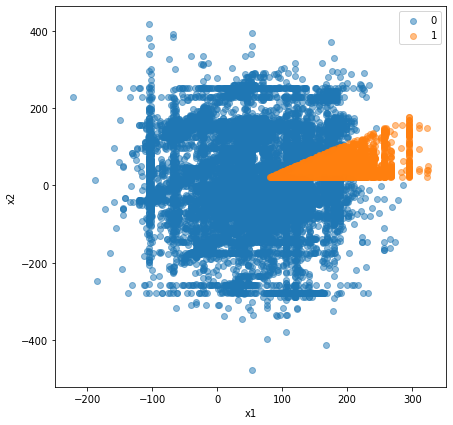

In [8]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### Tree with Depth 2

In [108]:
%%time
train_surrogate_tree(explanation, max_depth=2)

CPU times: user 13.5 ms, sys: 4.7 ms, total: 18.2 ms
Wall time: 20.3 ms


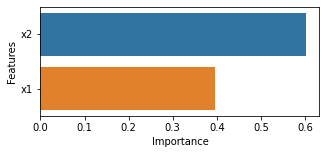

In [109]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

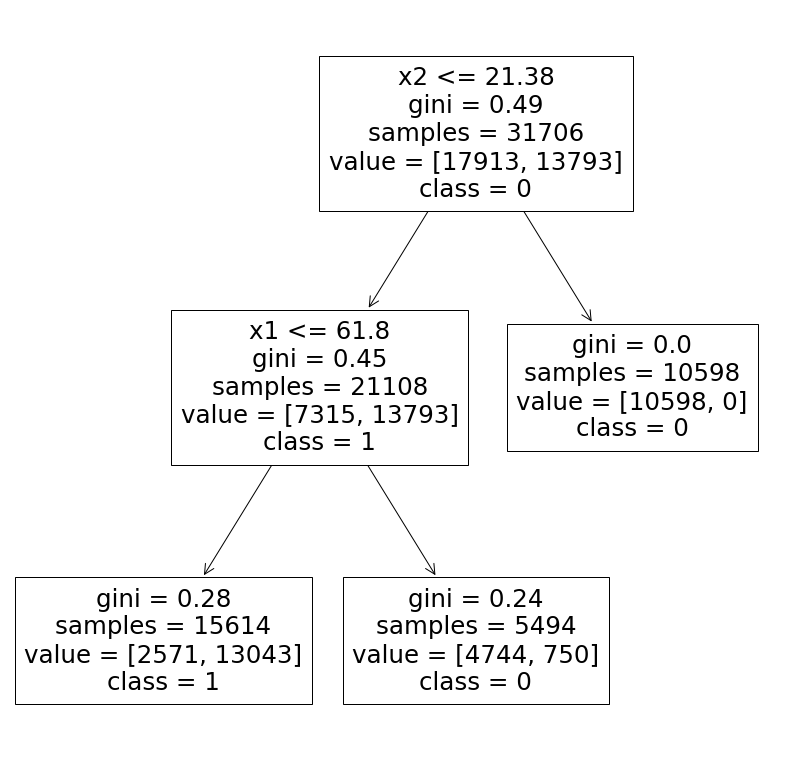

In [110]:
plot_surrogate_tree(explanation, precision=2)

In [111]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and x2 <= 21.377137184143066 [2571, 13043]


In [113]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)

17     1
19     1
46     1
128    0
134    1
199    1
201    1
226    1
231    1
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [112]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     17913
           1       0.84      0.95      0.89     13793

    accuracy                           0.90     31706
   macro avg       0.89      0.90      0.89     31706
weighted avg       0.90      0.90      0.90     31706



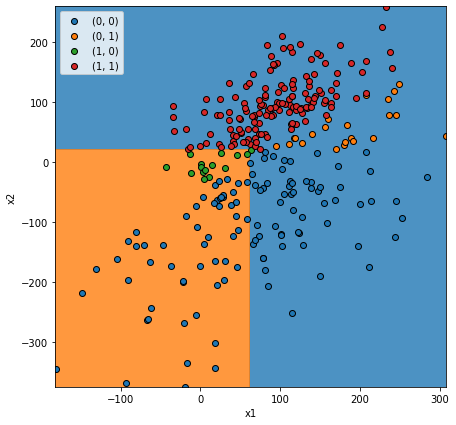

In [114]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [115]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       285
           1       0.20      0.93      0.33        15

    accuracy                           0.81       300
   macro avg       0.60      0.87      0.61       300
weighted avg       0.96      0.81      0.86       300



##### Counterfactual Fidelity Error

In [116]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [117]:
rmse

x1    26.407990
x2     0.077137
dtype: float64

In [118]:
boundary_miss_rate

x1    0.0
x2    0.5
dtype: float64

In [119]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Complexity

In [120]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 2 (2.0 per rule)


### Tree with Depth 3

In [121]:
%%time
train_surrogate_tree(explanation, max_depth=3)

CPU times: user 18.3 ms, sys: 11.9 ms, total: 30.2 ms
Wall time: 33.9 ms


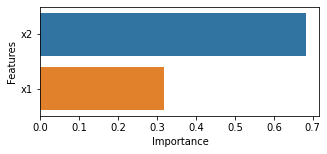

In [122]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

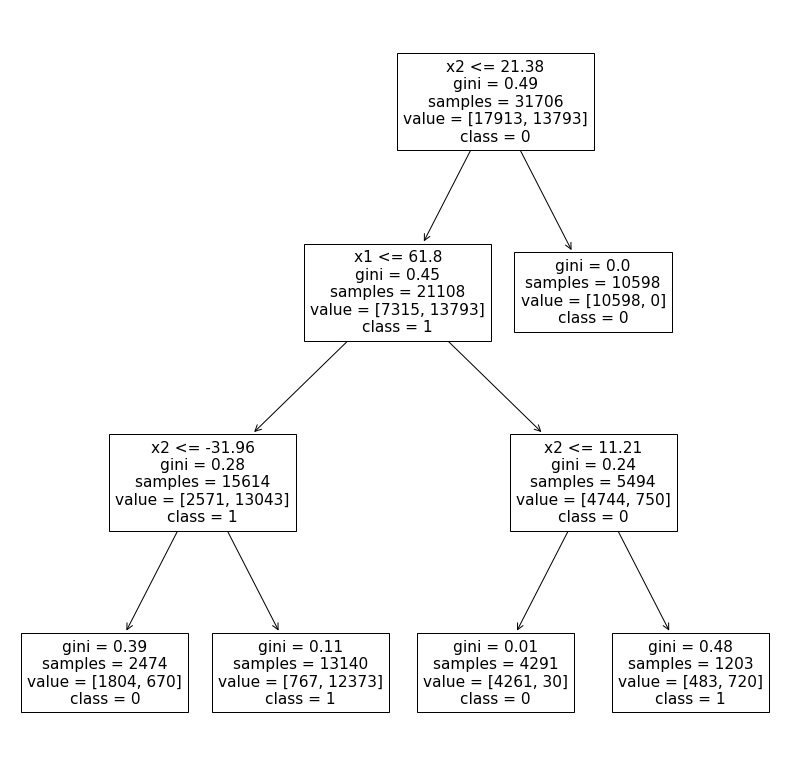

In [123]:
plot_surrogate_tree(explanation, precision=2)

In [124]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= 21.377137184143066 [767, 12373]
2. x1 > 61.80482482910156 and 11.214433193206787 < x2 <= 21.377137184143066 [483, 720]


In [125]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)

17     1
19     1
46     1
128    2
134    1
199    1
201    1
226    1
231    1
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [126]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     17913
           1       0.91      0.95      0.93     13793

    accuracy                           0.94     31706
   macro avg       0.94      0.94      0.94     31706
weighted avg       0.94      0.94      0.94     31706



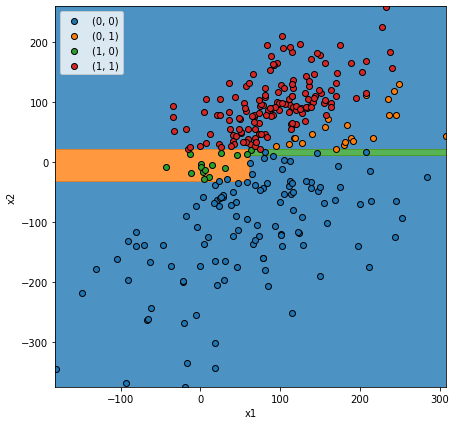

In [127]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [128]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       285
           1       0.75      1.00      0.86        15

    accuracy                           0.98       300
   macro avg       0.88      0.99      0.92       300
weighted avg       0.99      0.98      0.98       300



##### Counterfactual Fidelity Error

In [129]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [130]:
rmse

x1    26.407990
x2    12.477153
dtype: float64

In [131]:
boundary_miss_rate

x1    0.066667
x2    0.000000
dtype: float64

In [132]:
boundary_add_rate

x1    0.066667
x2    0.000000
dtype: float64

##### Complexity

In [133]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 6 (3.0 per rule)


### Tree with Depth 4

In [175]:
%%time
train_surrogate_tree(explanation, max_depth=4)

CPU times: user 24.1 ms, sys: 4.76 ms, total: 28.9 ms
Wall time: 30.3 ms


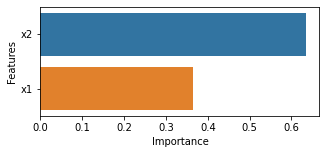

In [176]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

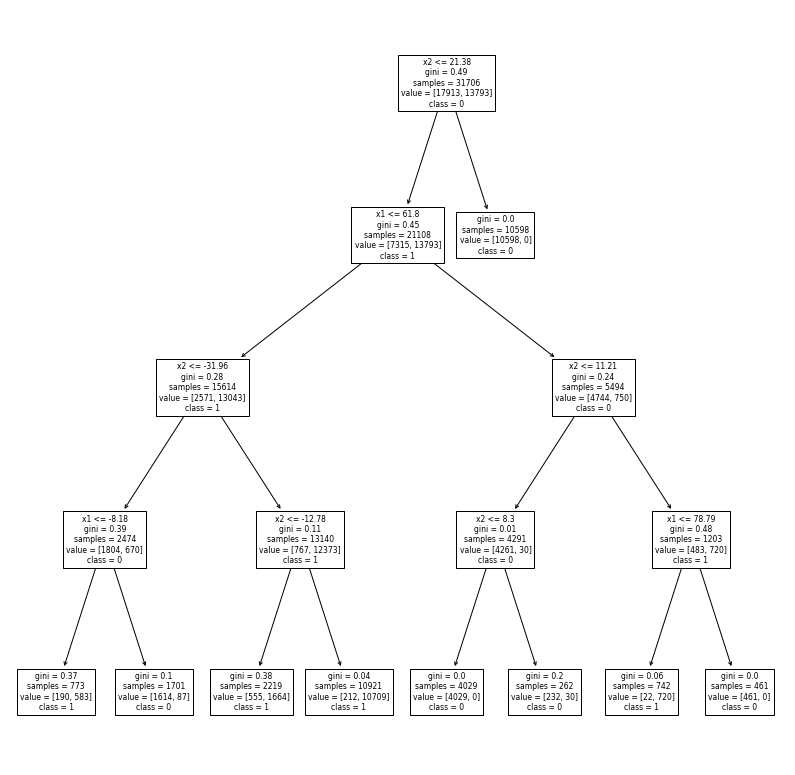

In [177]:
plot_surrogate_tree(explanation, precision=2)

In [178]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [212, 10709]
2. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= -12.77738094329834 [555, 1664]
3. x1 <= -8.175625324249268 and x2 <= -31.95584011077881 [190, 583]
4. 61.80482482910156 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [22, 720]


In [179]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     2
46     2
128    4
134    1
199    1
201    2
226    2
231    2
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [180]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [212, 10709]
2. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= -12.77738094329834 [555, 1664]
3. 61.80482482910156 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [22, 720]


In [181]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     17913
           1       0.93      0.99      0.96     13793

    accuracy                           0.97     31706
   macro avg       0.96      0.97      0.97     31706
weighted avg       0.97      0.97      0.97     31706



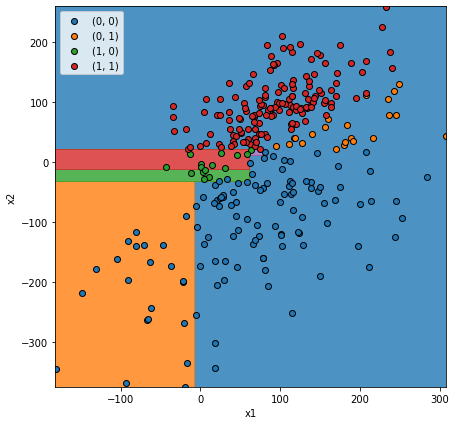

In [182]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

This explanation has higher precision (43\% to 54\%), so covers more instances classified differently, but has a higher CFE.

##### Global Fidelity

In [183]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       285
           1       0.38      1.00      0.56        15

    accuracy                           0.92       300
   macro avg       0.69      0.96      0.76       300
weighted avg       0.97      0.92      0.94       300



##### Counterfactual Fidelity Error

In [184]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [185]:
rmse

x1    25.513825
x2    20.464054
dtype: float64

In [186]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [187]:
boundary_add_rate

x1    0.0625
x2    0.0000
dtype: float64

##### Complexity

In [188]:
print_complexity(constraints)

Number of rules: 3
Number of constraints: 10 (3.3 per rule)


### Tree with Depth 5

In [189]:
%%time
train_surrogate_tree(explanation, max_depth=5)

CPU times: user 25.4 ms, sys: 11.2 ms, total: 36.6 ms
Wall time: 39.2 ms


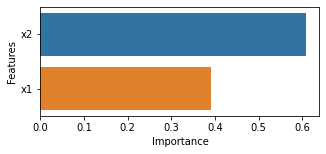

In [190]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

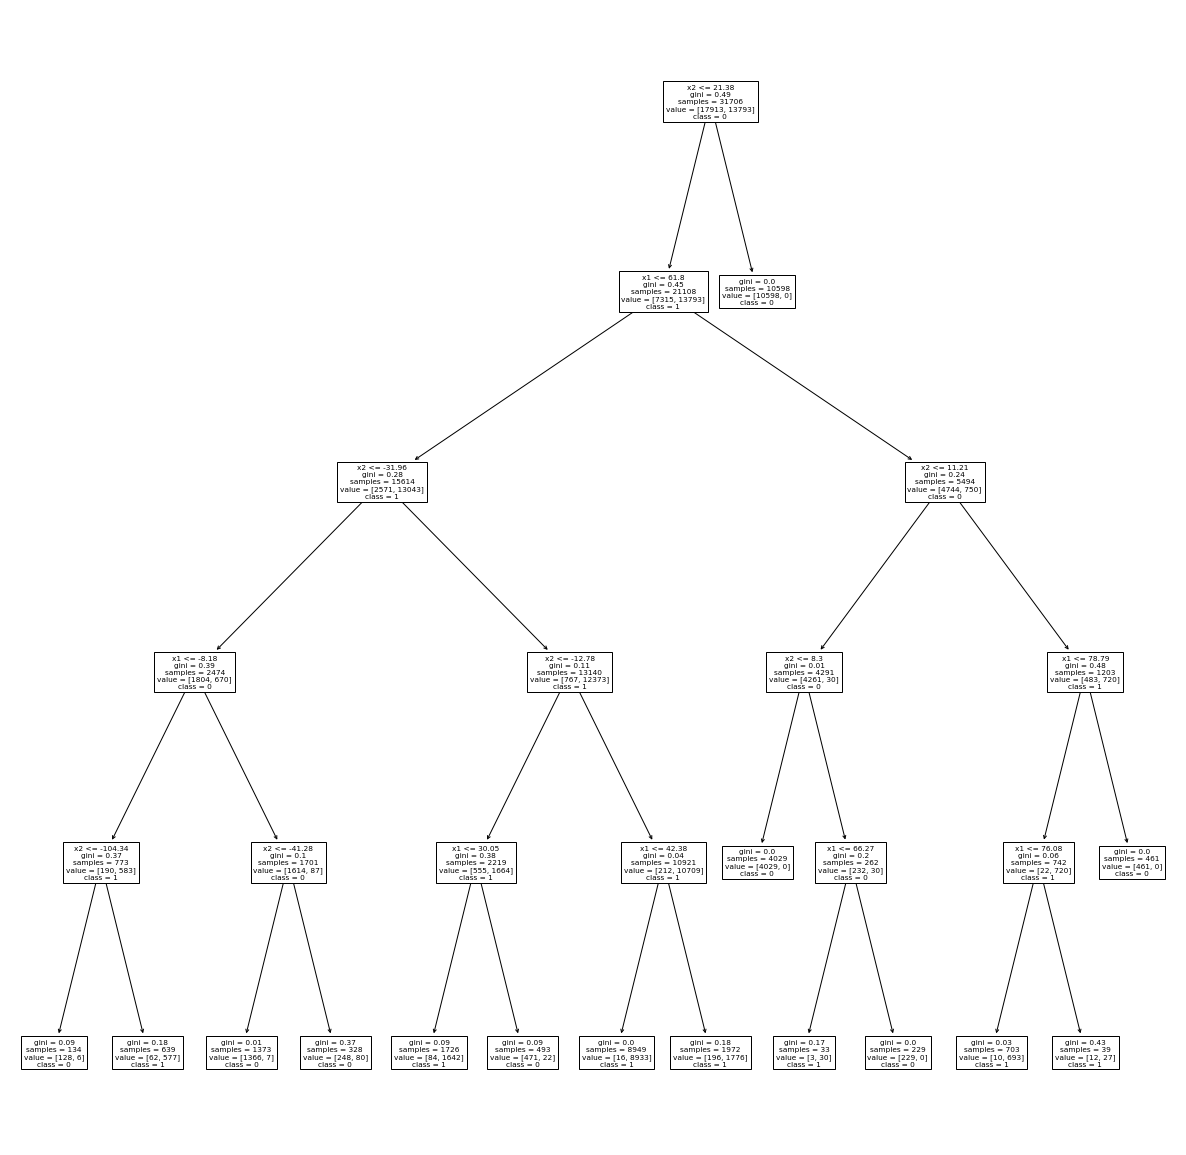

In [191]:
plot_surrogate_tree(explanation, precision=2, figsize=(21, 21))

In [192]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 42.37660217285156 and -12.77738094329834 < x2 <= 21.377137184143066 [16, 8933]
2. 42.37660217285156 < x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [196, 1776]
3. x1 <= 30.048880577087402 and -31.95584011077881 < x2 <= -12.77738094329834 [84, 1642]
4. 61.80482482910156 < x1 <= 76.08122634887695 and 11.214433193206787 < x2 <= 21.377137184143066 [10, 693]
5. x1 <= -8.175625324249268 and -104.34383392333984 < x2 <= -31.95584011077881 [62, 577]
6. 76.08122634887695 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [12, 27]
7. 61.80482482910156 < x1 <= 66.26707458496094 and 8.304028511047363 < x2 <= 11.214433193206787 [3, 30]


In [193]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     3
46     3
128    4
134    1
199    1
201    3
226    3
231    3
235    1
248    2
257    1
271    2
276    1
291    1
dtype: int64

In [194]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 42.37660217285156 and -12.77738094329834 < x2 <= 21.377137184143066 [16, 8933]
2. 42.37660217285156 < x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [196, 1776]
3. x1 <= 30.048880577087402 and -31.95584011077881 < x2 <= -12.77738094329834 [84, 1642]
4. 61.80482482910156 < x1 <= 76.08122634887695 and 11.214433193206787 < x2 <= 21.377137184143066 [10, 693]


In [195]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     17913
           1       0.97      0.99      0.98     13793

    accuracy                           0.98     31706
   macro avg       0.98      0.99      0.98     31706
weighted avg       0.98      0.98      0.98     31706



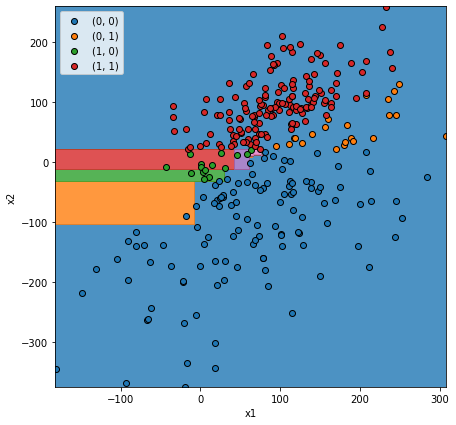

In [196]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [197]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       285
           1       0.88      1.00      0.94        15

    accuracy                           0.99       300
   macro avg       0.94      1.00      0.97       300
weighted avg       0.99      0.99      0.99       300



##### Counterfactual Fidelity Error

In [198]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [199]:
rmse

x1    12.380613
x2    20.464054
dtype: float64

In [200]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [201]:
boundary_add_rate

x1    0.166667
x2    0.000000
dtype: float64

##### Complexity

In [202]:
print_complexity(constraints)

Number of rules: 4
Number of constraints: 14 (3.5 per rule)


## $(1, 0)$

In [203]:
focus_class = '(1, 0)'
focus_class_idx = list(comparer.class_names).index(focus_class)

In [30]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanation), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 7min 27s, sys: 5.05 s, total: 7min 32s
Wall time: 8min 7s


In [204]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanation = pickle.load(f)

In [205]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Tree with Depth 2

In [206]:
%%time
train_surrogate_tree(explanation, max_depth=2)

CPU times: user 14.5 ms, sys: 7.03 ms, total: 21.5 ms
Wall time: 23.1 ms


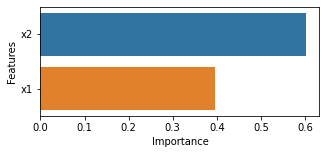

In [207]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

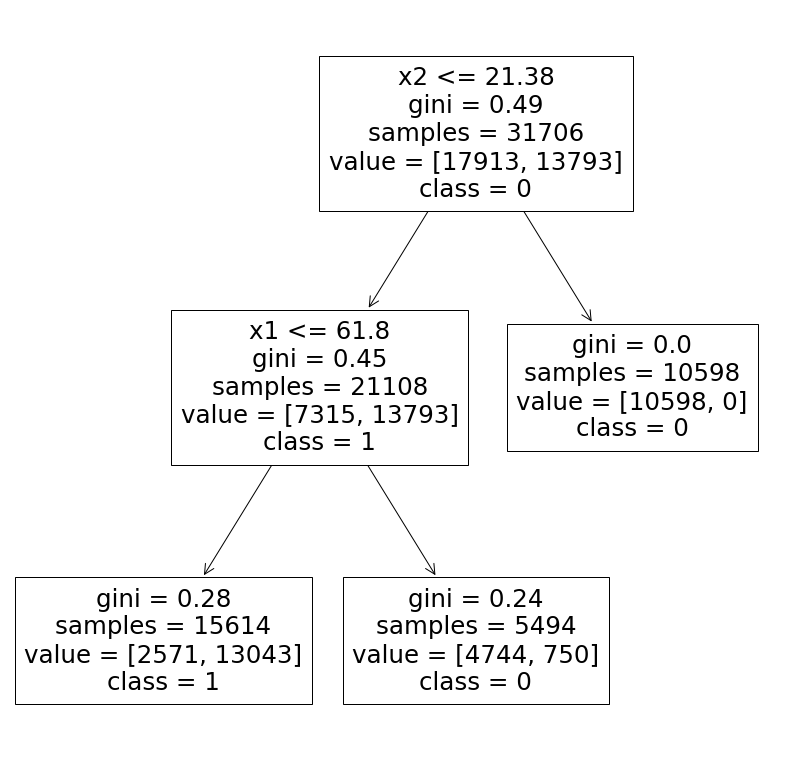

In [208]:
plot_surrogate_tree(explanation, precision=2)

In [209]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and x2 <= 21.377137184143066 [2571, 13043]


In [210]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     1
46     1
128    0
134    1
199    1
201    1
226    1
231    1
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [211]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and x2 <= 21.377137184143066 [2571, 13043]


In [212]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     17913
           1       0.84      0.95      0.89     13793

    accuracy                           0.90     31706
   macro avg       0.89      0.90      0.89     31706
weighted avg       0.90      0.90      0.90     31706



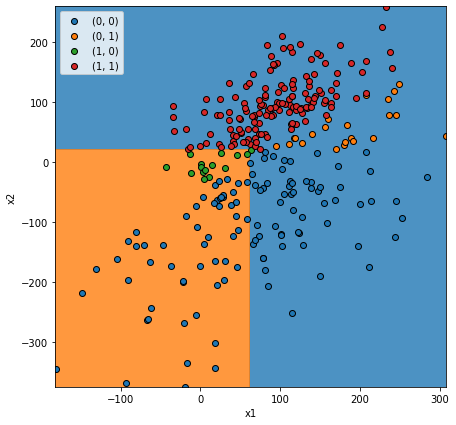

In [213]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [214]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       285
           1       0.20      0.93      0.33        15

    accuracy                           0.81       300
   macro avg       0.60      0.87      0.61       300
weighted avg       0.96      0.81      0.86       300



##### Counterfactual Fidelity Error

In [215]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [216]:
rmse

x1    26.407990
x2     0.077137
dtype: float64

In [217]:
boundary_miss_rate

x1    0.0
x2    0.5
dtype: float64

In [218]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Complexity

In [219]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 2 (2.0 per rule)


### Tree with Depth 3

In [220]:
%%time
train_surrogate_tree(explanation, max_depth=3)

CPU times: user 19 ms, sys: 8.2 ms, total: 27.2 ms
Wall time: 34.2 ms


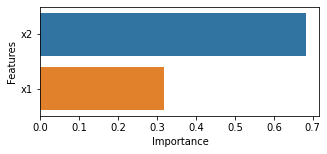

In [221]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

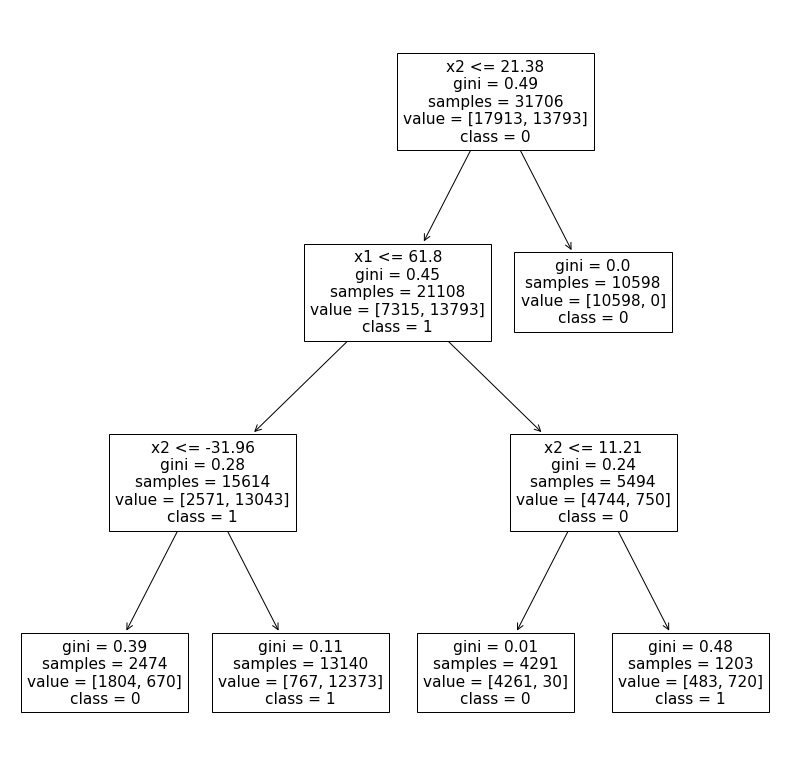

In [222]:
plot_surrogate_tree(explanation, precision=2)

In [223]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= 21.377137184143066 [767, 12373]
2. x1 > 61.80482482910156 and 11.214433193206787 < x2 <= 21.377137184143066 [483, 720]


In [224]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     1
46     1
128    2
134    1
199    1
201    1
226    1
231    1
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [225]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= 21.377137184143066 [767, 12373]
2. x1 > 61.80482482910156 and 11.214433193206787 < x2 <= 21.377137184143066 [483, 720]


In [226]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     17913
           1       0.91      0.95      0.93     13793

    accuracy                           0.94     31706
   macro avg       0.94      0.94      0.94     31706
weighted avg       0.94      0.94      0.94     31706



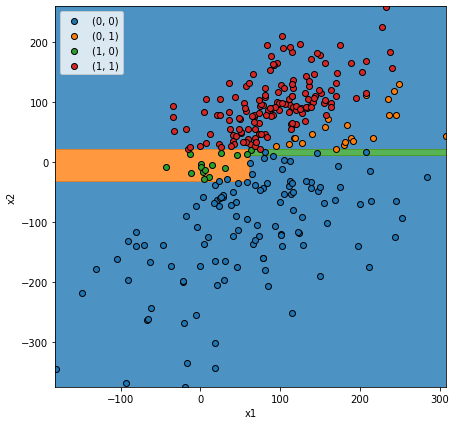

In [227]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [228]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       285
           1       0.75      1.00      0.86        15

    accuracy                           0.98       300
   macro avg       0.88      0.99      0.92       300
weighted avg       0.99      0.98      0.98       300



##### Counterfactual Fidelity Error

In [229]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [230]:
rmse

x1    26.407990
x2    12.477153
dtype: float64

In [231]:
boundary_miss_rate

x1    0.066667
x2    0.000000
dtype: float64

In [232]:
boundary_add_rate

x1    0.066667
x2    0.000000
dtype: float64

##### Complexity

In [233]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 6 (3.0 per rule)


### Tree with Depth 4

In [234]:
%%time
train_surrogate_tree(explanation, max_depth=4)

CPU times: user 22.1 ms, sys: 7.97 ms, total: 30.1 ms
Wall time: 34.2 ms


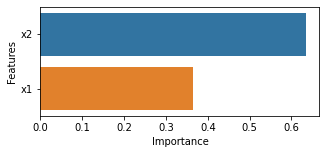

In [235]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

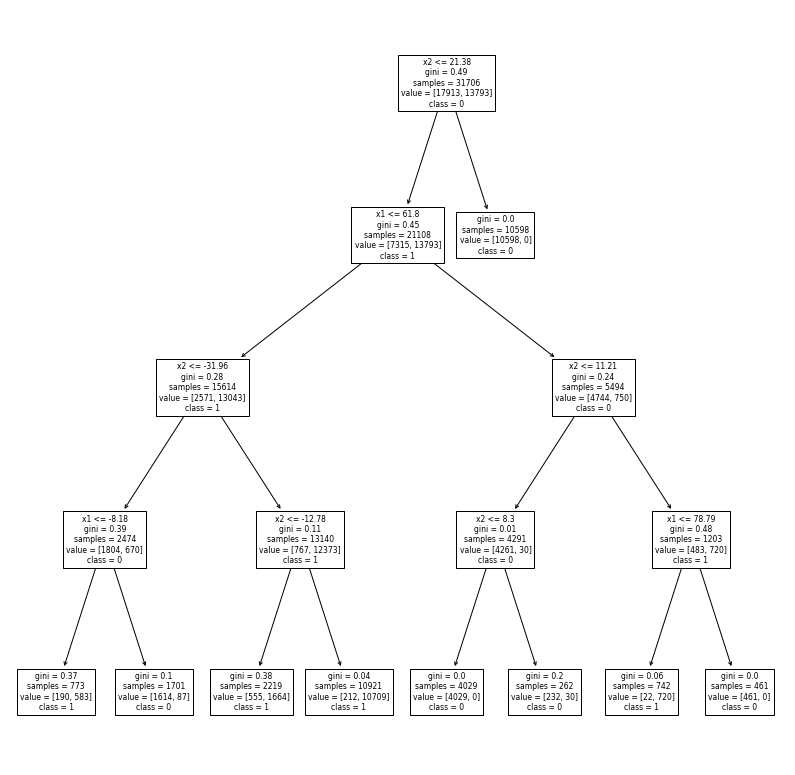

In [236]:
plot_surrogate_tree(explanation, precision=2)

In [237]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [212, 10709]
2. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= -12.77738094329834 [555, 1664]
3. x1 <= -8.175625324249268 and x2 <= -31.95584011077881 [190, 583]
4. 61.80482482910156 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [22, 720]


In [238]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     2
46     2
128    4
134    1
199    1
201    2
226    2
231    2
235    1
248    1
257    1
271    1
276    1
291    1
dtype: int64

In [239]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [212, 10709]
2. x1 <= 61.80482482910156 and -31.95584011077881 < x2 <= -12.77738094329834 [555, 1664]
3. 61.80482482910156 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [22, 720]


In [240]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     17913
           1       0.93      0.99      0.96     13793

    accuracy                           0.97     31706
   macro avg       0.96      0.97      0.97     31706
weighted avg       0.97      0.97      0.97     31706



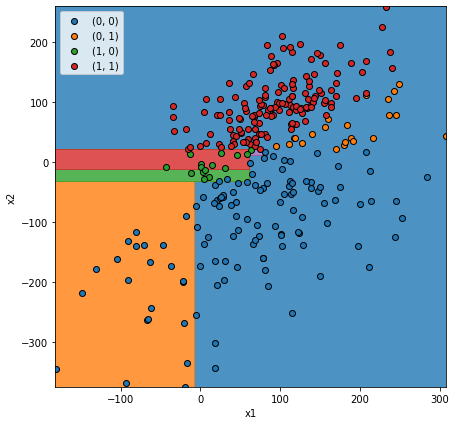

In [241]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [242]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       285
           1       0.38      1.00      0.56        15

    accuracy                           0.92       300
   macro avg       0.69      0.96      0.76       300
weighted avg       0.97      0.92      0.94       300



##### Counterfactual Fidelity Error

In [243]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [244]:
rmse

x1    25.513825
x2    20.464054
dtype: float64

In [245]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [246]:
boundary_add_rate

x1    0.0625
x2    0.0000
dtype: float64

##### Complexity

In [247]:
print_complexity(constraints)

Number of rules: 3
Number of constraints: 10 (3.3 per rule)


### Tree with Depth 5

In [248]:
%%time
train_surrogate_tree(explanation, max_depth=5)

CPU times: user 27.2 ms, sys: 7.09 ms, total: 34.3 ms
Wall time: 36.4 ms


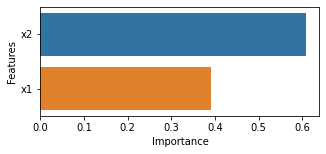

In [249]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

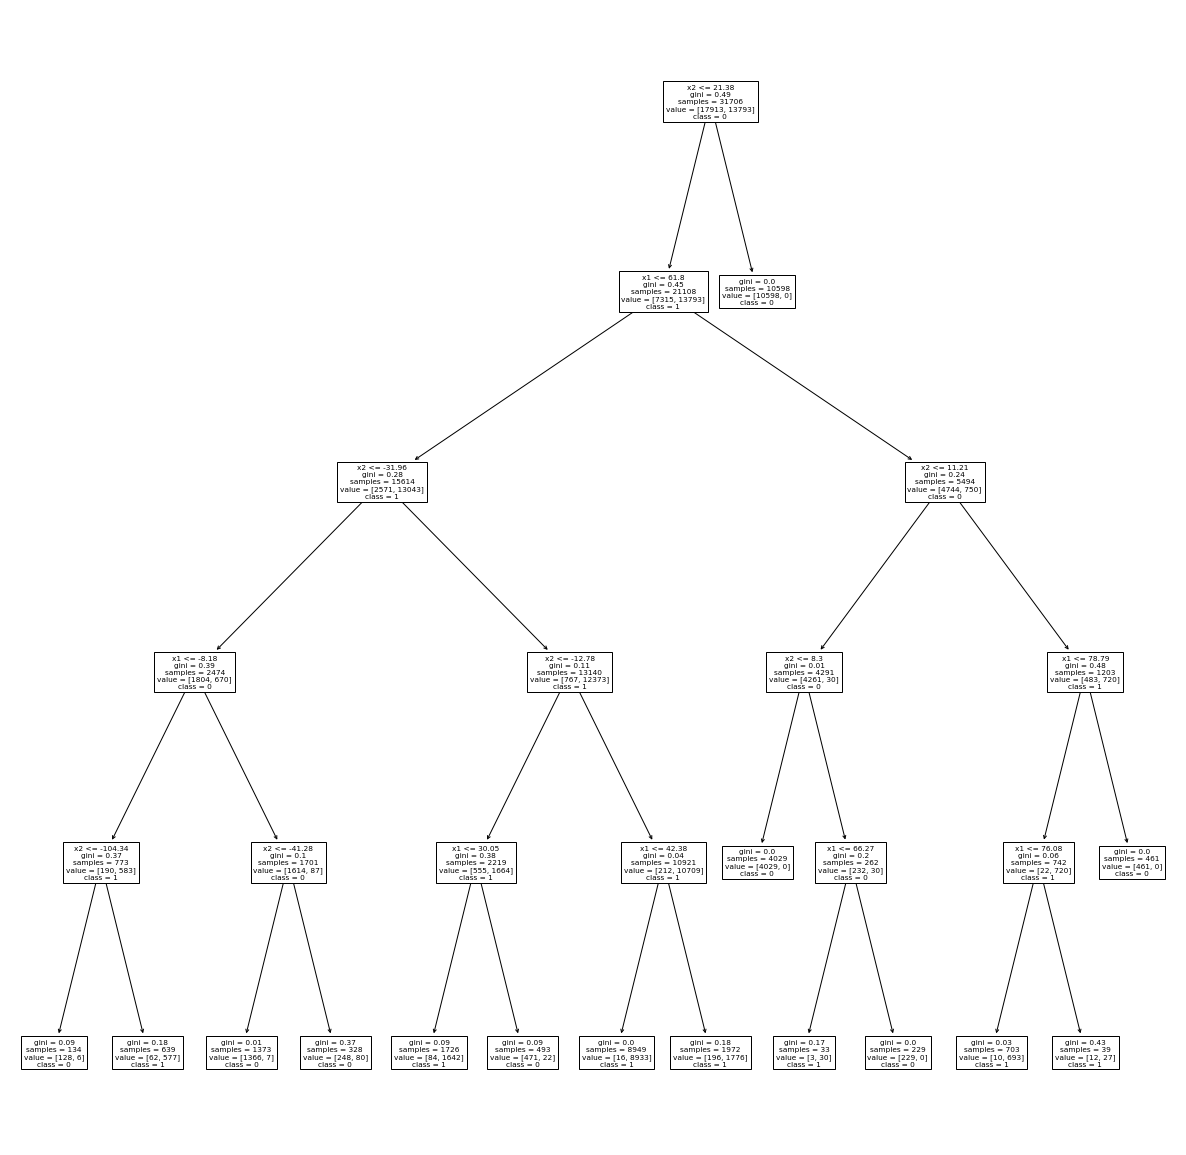

In [250]:
plot_surrogate_tree(explanation, precision=2, figsize=(21, 21))

In [251]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. x1 <= 42.37660217285156 and -12.77738094329834 < x2 <= 21.377137184143066 [16, 8933]
2. 42.37660217285156 < x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [196, 1776]
3. x1 <= 30.048880577087402 and -31.95584011077881 < x2 <= -12.77738094329834 [84, 1642]
4. 61.80482482910156 < x1 <= 76.08122634887695 and 11.214433193206787 < x2 <= 21.377137184143066 [10, 693]
5. x1 <= -8.175625324249268 and -104.34383392333984 < x2 <= -31.95584011077881 [62, 577]
6. 76.08122634887695 < x1 <= 78.79093933105469 and 11.214433193206787 < x2 <= 21.377137184143066 [12, 27]
7. 61.80482482910156 < x1 <= 66.26707458496094 and 8.304028511047363 < x2 <= 11.214433193206787 [3, 30]


In [252]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

17     1
19     3
46     3
128    4
134    1
199    1
201    3
226    3
231    3
235    1
248    2
257    1
271    2
276    1
291    1
dtype: int64

In [253]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. x1 <= 42.37660217285156 and -12.77738094329834 < x2 <= 21.377137184143066 [16, 8933]
2. 42.37660217285156 < x1 <= 61.80482482910156 and -12.77738094329834 < x2 <= 21.377137184143066 [196, 1776]
3. x1 <= 30.048880577087402 and -31.95584011077881 < x2 <= -12.77738094329834 [84, 1642]
4. 61.80482482910156 < x1 <= 76.08122634887695 and 11.214433193206787 < x2 <= 21.377137184143066 [10, 693]


In [254]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     17913
           1       0.97      0.99      0.98     13793

    accuracy                           0.98     31706
   macro avg       0.98      0.99      0.98     31706
weighted avg       0.98      0.98      0.98     31706



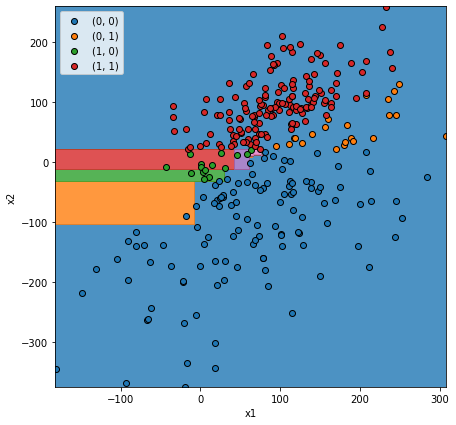

In [255]:
plot_tree_leafs_2d(explanation, comparer, X)

#### Evaluation

##### Global Fidelity

In [256]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       285
           1       0.88      1.00      0.94        15

    accuracy                           0.99       300
   macro avg       0.94      1.00      0.97       300
weighted avg       0.99      0.99      0.99       300



##### Counterfactual Fidelity Error

In [257]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [258]:
rmse

x1    12.380613
x2    20.464054
dtype: float64

In [259]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [260]:
boundary_add_rate

x1    0.166667
x2    0.000000
dtype: float64

##### Complexity

In [261]:
print_complexity(constraints)

Number of rules: 4
Number of constraints: 14 (3.5 per rule)


# Summary

## Global Fidelity

Ruleset | Precision | Recall | F1
 --- | --- | --- | ---
01/global | 26\% | 95\% | 40\%
01/level 1 | 43\% | 82\% | 56\%
01/level 2 | 54\% | 100\% | 70\%
01/level 3 | 69\% | 100\% | 81\%
10/global | 20\% | 93\% | 33\%
10/level 1 | 75\% | 100\% | 86\%
10/level 2 | 38\% | 100\% | 56\%
10/level 3 | 88\% | 100\% | 94\%

## Counterfactual Fidelity Error

Ruleset | RMSE | boundaries missed | unnecessary boundaries
 --- | --- | --- | ---
01/global | 34.4 | 33.3% | 0.0%
01/level 1 | 25.0 | 1.9\% | 1.9\%
01/level 2 | 31.5 | 6.1\% | 1.6\%
01/level 3 | 30.0 | 0\% | 5.7\%
10/global | 18.7 | 33.3\% | 0\%
10/level 1 | 18.1 | 2.2\% | 2.2\%
10/level 2 | 22.3 | 0\% | 2.2\%
10/level 3 | 18.2 | 0\% | 6.2\%

## Complexity

Ruleset | # Rules | # Constraints
 --- | --- | ---
01/global | 1 | 2
01/level 1 | 2 | 6
01/level 2 | 4 | 12
01/level 3 | 8 | 27
10/global | 1 | 2
10/level 1 | 2 | 6
10/level 2 | 4 | 12
10/level 3 | 7 | 25

## Generation Time

approx. 15min.